Start: (700, 200)
Waypoints: [(100, 200), (100, 700)]
End: (700, 200)
Complete Path: [(700, 200), (699, 199), (698, 198), (697, 197), (696, 196), (695, 195), (694, 194), (693, 193), (693, 192), (693, 191), (693, 190), (694, 189), (693, 188), (693, 187), (694, 186), (694, 185), (694, 184), (693, 183), (692, 182), (691, 181), (690, 180), (689, 179), (688, 178), (687, 177), (686, 176), (685, 175), (684, 174), (683, 173), (682, 172), (681, 171), (680, 170), (679, 169), (678, 168), (677, 167), (676, 166), (675, 165), (674, 164), (673, 163), (672, 162), (671, 161), (670, 160), (669, 159), (669, 158), (669, 157), (669, 156), (669, 155), (669, 154), (669, 153), (669, 152), (669, 151), (668, 150), (668, 149), (668, 148), (668, 147), (668, 146), (667, 145), (666, 144), (665, 143), (664, 142), (663, 141), (662, 140), (661, 139), (660, 138), (659, 137), (658, 136), (657, 135), (656, 134), (655, 133), (654, 132), (653, 131), (652, 130), (651, 129), (650, 128), (649, 127), (648, 126), (647, 125), (6

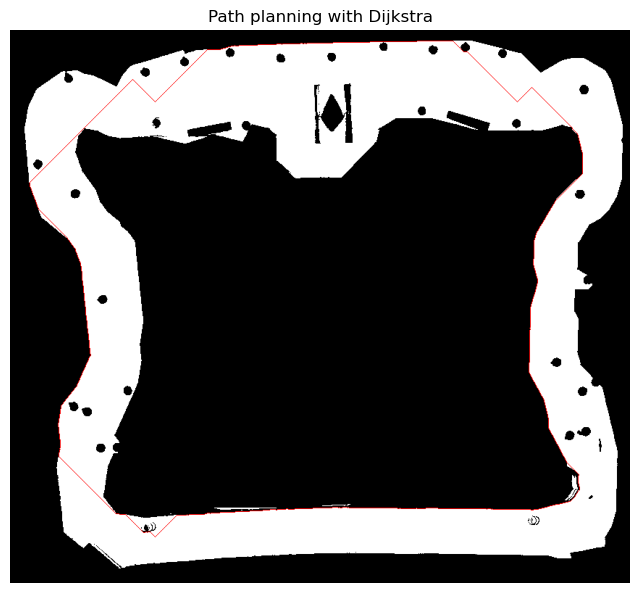

In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import csv

file_path = r'C:\Users\boddu\Downloads\map_soc_walls_3_modified.npy'
soc1_map = np.load(file_path)

if soc1_map.ndim == 3:
    soc1_map = np.mean(soc1_map, axis=2)

binary_map = np.where(soc1_map > 128, 1, 0)   

start_provided = (700, 200)
waypoints_provided = [(100, 200), (100, 700)]
end_provided = (700, 200)

def find_nearest_white_lane(map_array, coord):
    x, y = coord
    if map_array[x, y] == 1:
        return coord
    
    directions = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2)]
    
    radius = 1
    while radius < max(map_array.shape):
        for dx, dy in directions:
            new_x, new_y = x + dx * radius, y + dy * radius
            if 0 <= new_x < map_array.shape[0] and 0 <= new_y < map_array.shape[1]:
                if map_array[new_x, new_y] == 1:
                    return (new_x, new_y)
        radius += 1
    return None

start = find_nearest_white_lane(binary_map, start_provided)
waypoints = [find_nearest_white_lane(binary_map, wp) for wp in waypoints_provided]
end = find_nearest_white_lane(binary_map, end_provided)

print(f"Start: {start}")
print(f"Waypoints: {waypoints}")
print(f"End: {end}")

def dijkstra_with_bias(map_array, start, end):
    # Initialize distances with infinity and set start distance to 0
    distances = {start: 0}
    priority_queue = [(0, start)]
    came_from = {start: None}

    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (-1,1), (1,1), (1,-1), (-1,-1)]
    
    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)
        
        if current_node == end:
            path = []
            while current_node:
                path.append(current_node)
                current_node = came_from[current_node]
            return path[::-1]   
            
        current_x, current_y = current_node
        for dx, dy in directions:
            neighbor = (current_x + dx, current_y + dy)
            neighbor_x, neighbor_y = neighbor

            if 0 <= neighbor_x < map_array.shape[0] and 0 <= neighbor_y < map_array.shape[1]:
                if map_array[neighbor_x, neighbor_y] == 1:
                    distance = current_distance + 1  # All edges have the same weight
                    if distance < distances.get(neighbor, float('inf')):
                        distances[neighbor] = distance
                        heapq.heappush(priority_queue, (distance, neighbor))
                        came_from[neighbor] = current_node

    return None   

def find_combined_path(map_array, start, waypoints, end):
    combined_path = []

    for i in range(len(waypoints)):
        if i == 0:
            path_start_to_wp = dijkstra_with_bias(map_array, start, waypoints[i])
        else:
            path_start_to_wp = dijkstra_with_bias(map_array, waypoints[i-1], waypoints[i])

        if path_start_to_wp is not None:
            combined_path.extend(path_start_to_wp)

    path_wp_to_end = dijkstra_with_bias(map_array, waypoints[-1], end)
    if path_wp_to_end is not None:
        combined_path.extend(path_wp_to_end[1:])   

    return combined_path


path = find_combined_path(binary_map, start, waypoints, end)
print(f"Complete Path: {path}")

csv_file_path = r'C:\Users\boddu\Downloads\path_coordinates.csv'
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["x", "y"])
    for coord in path:
        writer.writerow(coord)

print(f"Path coordinates saved to {csv_file_path}")

if path is None:
    print("No valid complete path found within the white lane.")
else:
    
    visual_map = np.copy(binary_map)

     
    for (x, y) in path:
        visual_map[x, y] = 2  
        
    colors = {0: [0, 0, 0], 1: [255, 255, 255], 2: [255, 0, 0]}
    color_map = np.zeros((visual_map.shape[0], visual_map.shape[1], 3), dtype=np.uint8)

    
    for i in range(visual_map.shape[0]):
        for j in range(visual_map.shape[1]):
            color_map[i, j] = colors[visual_map[i, j]]

    plt.figure(figsize=(8, 8))
    plt.imshow(color_map)
    plt.title("Path planning with Dijkstra")
    plt.axis('off')
    plt.show()


Start: (700, 200)
Waypoints: [(100, 200), (100, 700)]
End: (700, 200)
Time taken to find the complete path: 5.95 seconds
Complete Path: [(700, 200), (699, 200), (698, 200), (697, 200), (696, 200), (695, 200), (694, 200), (694, 199), (694, 198), (694, 197), (694, 196), (694, 195), (694, 194), (694, 193), (694, 192), (694, 191), (694, 190), (694, 189), (694, 188), (694, 187), (694, 186), (694, 185), (694, 184), (694, 183), (693, 183), (693, 182), (692, 182), (692, 181), (691, 181), (690, 181), (689, 181), (689, 180), (688, 180), (687, 180), (686, 180), (685, 180), (684, 180), (683, 180), (682, 180), (681, 180), (680, 180), (679, 180), (678, 180), (677, 180), (676, 180), (675, 180), (674, 180), (673, 180), (673, 179), (673, 178), (673, 177), (673, 176), (672, 176), (672, 175), (672, 174), (672, 173), (672, 172), (672, 171), (672, 170), (671, 170), (671, 169), (671, 168), (671, 167), (671, 166), (671, 165), (671, 164), (670, 164), (670, 163), (670, 162), (670, 161), (670, 160), (669, 160),

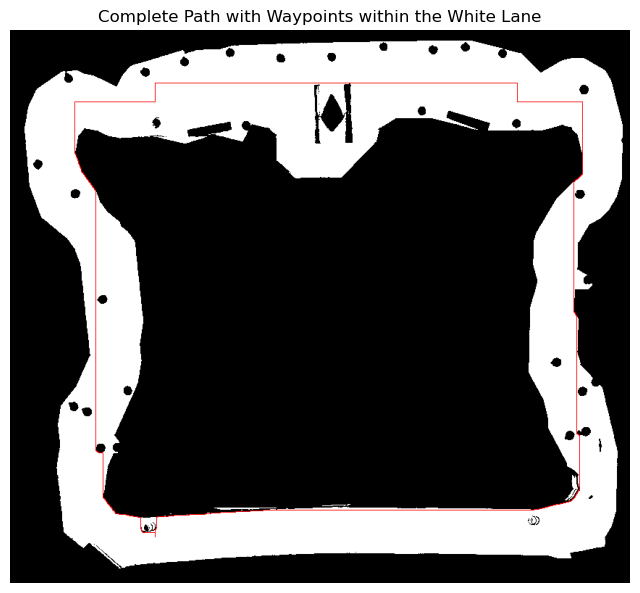

In [2]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import csv
import time

file_path = r'C:\Users\boddu\Downloads\map_soc_walls_3_modified.npy'
soc1_map = np.load(file_path)

if soc1_map.ndim == 3:
    soc1_map = np.mean(soc1_map, axis=2)
 
binary_map = np.where(soc1_map > 128, 1, 0)  

start_provided = (700, 200)
waypoints_provided = [(100, 200), (100, 700)]
end_provided = (700, 200)

def find_nearest_white_lane(map_array, coord):
    x, y = coord
    if map_array[x, y] == 1:
        return coord
    
    directions = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2)]
    
    radius = 1
    while radius < max(map_array.shape):
        for dx, dy in directions:
            new_x, new_y = x + dx * radius, y + dy * radius
            if 0 <= new_x < map_array.shape[0] and 0 <= new_y < map_array.shape[1]:
                if map_array[new_x, new_y] == 1:
                    return (new_x, new_y)
        radius += 1
    return None

start = find_nearest_white_lane(binary_map, start_provided)
waypoints = [find_nearest_white_lane(binary_map, wp) for wp in waypoints_provided]
end = find_nearest_white_lane(binary_map, end_provided)

print(f"Start: {start}")
print(f"Waypoints: {waypoints}")
print(f"End: {end}")

def dijkstra_with_bias(map_array, start, end):
    distances = {start: 0}
    priority_queue = [(0, start)]
    came_from = {start: None}
 
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    
    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)
        
        if current_node == end:
            path = []
            while current_node:
                path.append(current_node)
                current_node = came_from[current_node]
            return path[::-1]   
            
        current_x, current_y = current_node
        for dx, dy in directions:
            neighbor = (current_x + dx, current_y + dy)
            neighbor_x, neighbor_y = neighbor

            if 0 <= neighbor_x < map_array.shape[0] and 0 <= neighbor_y < map_array.shape[1]:
                if map_array[neighbor_x, neighbor_y] == 1:
                    distance = current_distance + 1   
                    if distance < distances.get(neighbor, float('inf')):
                        distances[neighbor] = distance
                        heapq.heappush(priority_queue, (distance, neighbor))
                        came_from[neighbor] = current_node

    return None   

def find_combined_path(map_array, start, waypoints, end):
    
    combined_path = []

    
    for i in range(len(waypoints)):
        if i == 0:
            path_start_to_wp = dijkstra_with_bias(map_array, start, waypoints[i])
        else:
            path_start_to_wp = dijkstra_with_bias(map_array, waypoints[i-1], waypoints[i])

        if path_start_to_wp is not None:
            combined_path.extend(path_start_to_wp)

    
    path_wp_to_end = dijkstra_with_bias(map_array, waypoints[-1], end)
    if path_wp_to_end is not None:
        combined_path.extend(path_wp_to_end[1:])   

    return combined_path
 
start_time = time.time()

 
path = find_combined_path(binary_map, start, waypoints, end)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to find the complete path: {elapsed_time:.2f} seconds")

print(f"Complete Path: {path}")

csv_file_path = r'C:\Users\boddu\Downloads\path_coordinates.csv'
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["x", "y"])
    for coord in path:
        writer.writerow(coord)

print(f"Path coordinates saved to {csv_file_path}")

if path is None:
    print("No valid complete path found within the white lane.")
else:
    visual_map = np.copy(binary_map)

    for (x, y) in path:
        visual_map[x, y] = 2   
        
    colors = {0: [0, 0, 0], 1: [255, 255, 255], 2: [255, 0, 0]}
    color_map = np.zeros((visual_map.shape[0], visual_map.shape[1], 3), dtype=np.uint8)

    for i in range(visual_map.shape[0]):
        for j in range(visual_map.shape[1]):
            color_map[i, j] = colors[visual_map[i, j]]
            
    plt.figure(figsize=(8, 8))
    plt.imshow(color_map)
    plt.title("Complete Path with Waypoints within the White Lane")
    plt.axis('off')
    plt.show()
